# Churn prediction

Customer churn, also known as customer attrition, occurs when customers stop doing business with a company. The companies are interested in identifying segments of these customers because the price for acquiring a new customer is usually higher than retaining the old one. For example, if Netflix knew a segment of customers who were at risk of churning they could proactively engage them with special offers instead of simply losing them.

In this blog post, we will create a simple customer churn prediction model using [Telco Customer Churn dataset](https://www.kaggle.com/blastchar/telco-customer-churn).  We chose a decision tree to model churned customers, pandas for data crunching and matplotlib for visualizations. We will do all of that above in Python.
The code can be used with another dataset with a few minor adjustments to train the baseline model. We also provide few references and give ideas for new features and improvements. 

You can run this code by downloading this [Jupyter notebook]({{site.url}}/assets/notebooks/2019-01-25-churn-prediction).
    
Follow me on [twitter](https://twitter.com/romanorac) to get latest updates.

Let's get started.

## Requirements

In [1]:
import platform
import pandas as pd
import sklearn
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print('python version', platform.python_version())
print('pandas version', pd.__version__)
print('sklearn version', sklearn.__version__)
print('numpy version', np.__version__)
print('graphviz version', graphviz.__version__)
print('matplotlib version', matplotlib.__version__)

python version 3.7.7
pandas version 1.0.5
sklearn version 0.23.1
numpy version 1.18.5
graphviz version 0.14
matplotlib version 3.2.2


## Data Preprocessing

We use pandas to read the dataset and preprocess it. Telco dataset has one customer per line with many columns (features).
There aren't any rows with all missing values or duplicates (this rarely happens with real-world datasets). 
There are 11 samples that have TotalCharges set to " ", which seems like a mistake in the data. We remove those samples and set the type to numeric (float).

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.shape

(7043, 21)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df = df.dropna(how="all")  # remove samples with all missing values
df.shape

(7043, 21)

In [6]:
df = df[~df.duplicated()] # remove duplicates
df.shape

(7043, 21)

In [7]:
total_charges_filter = df.TotalCharges == " "
df = df[~total_charges_filter]
df.shape

(7032, 21)

In [8]:
df.TotalCharges = pd.to_numeric(df.TotalCharges)

## Exploratory Data Analysis

We have 2 types of features in the dataset: categorical (two or more values and without any order) and numerical. Most of the feature names are self-explanatory, except for:
 - Partner: whether the customer has a partner or not (Yes, No),
 - Dependents: whether the customer has dependents or not (Yes, No),
 - OnlineBackup: whether the customer has online backup or not (Yes, No, No internet service),
 - tenure: number of months the customer has stayed with the company,
 - MonthlyCharges: the amount charged to the customer monthly,
 - TotalCharges: the total amount charged to the customer.
 
There are 7032 customers in the dataset and 19 features without customerID (non-informative) and Churn column (target variable). Most of the categorical features have 4 or less unique values.

In [9]:
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032,7032,7032.000000,7032,7032,7032.000000,7032,7032,7032,7032,...,7032,7032,7032,7032,7032,7032,7032,7032.000000,7032.000000,7032
unique,7032,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7225-IILWY,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,3549,NaN,3639,4933,NaN,6352,3385,3096,3497,...,3094,3472,2809,2781,3875,4168,2365,NaN,NaN,5163
mean,NaN,NaN,0.162400,NaN,NaN,32.421786,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.798208,2283.300441,NaN
std,NaN,NaN,0.368844,NaN,NaN,24.545260,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.085974,2266.771362,NaN
min,NaN,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.587500,401.450000,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.862500,3794.737500,NaN


In [10]:
categorical_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
target = "Churn"

### Feature distribution

We plot distributions for numerical and categorical features to check for outliers and compare feature distributions with target variable.

#### Numerical features distribution

Numeric summarizing techniques (mean, standard deviation, etc.) don't show us spikes, shapes of distributions and it is hard to observe outliers with it. That is the reason we use histograms.

In [11]:
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


At first glance, there aren't any outliers in the data. No data point is disconnected from distribution or too far from the mean value. To confirm that we would need to calculate [interquartile range (IQR)](https://www.purplemath.com/modules/boxwhisk3.htm) and show that values of each numerical feature are within the 1.5 IQR from first and third quartile. 

We could convert numerical features to ordinal intervals. For example, tenure is numerical, but often we don't care about small numeric differences and instead group tenure to customers with short, medium and long term tenure. One reason to convert it would be to reduce the noise, often small fluctuates are just noise.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028A5CC7B208>,
      dtype=object)

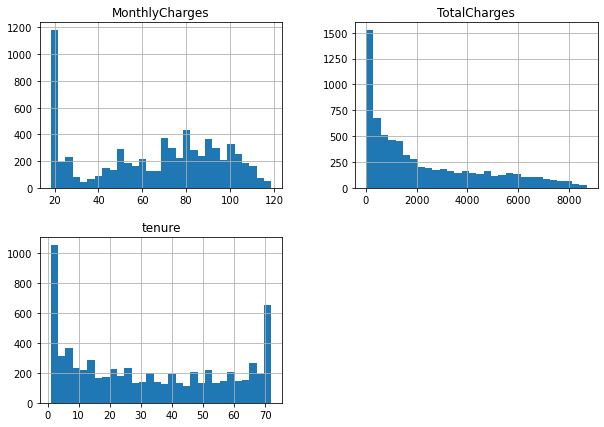

In [12]:
df[numerical_features].hist(bins=30, figsize=(10, 7))

We look at distributions of numerical features in relation to the target variable. We can observe that the greater TotalCharges and tenure are the less is the probability of churn.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000028A5D3E2AC8>,
      dtype=object)

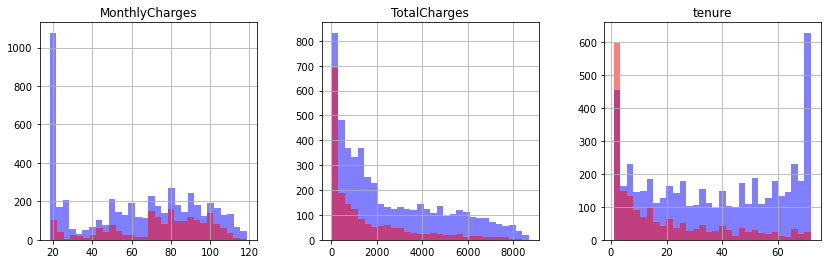

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

#### Categorical feature distribution

To analyze categorical features, we use bar charts. We observe that Senior citizens and customers without phone service are less represented in the data.

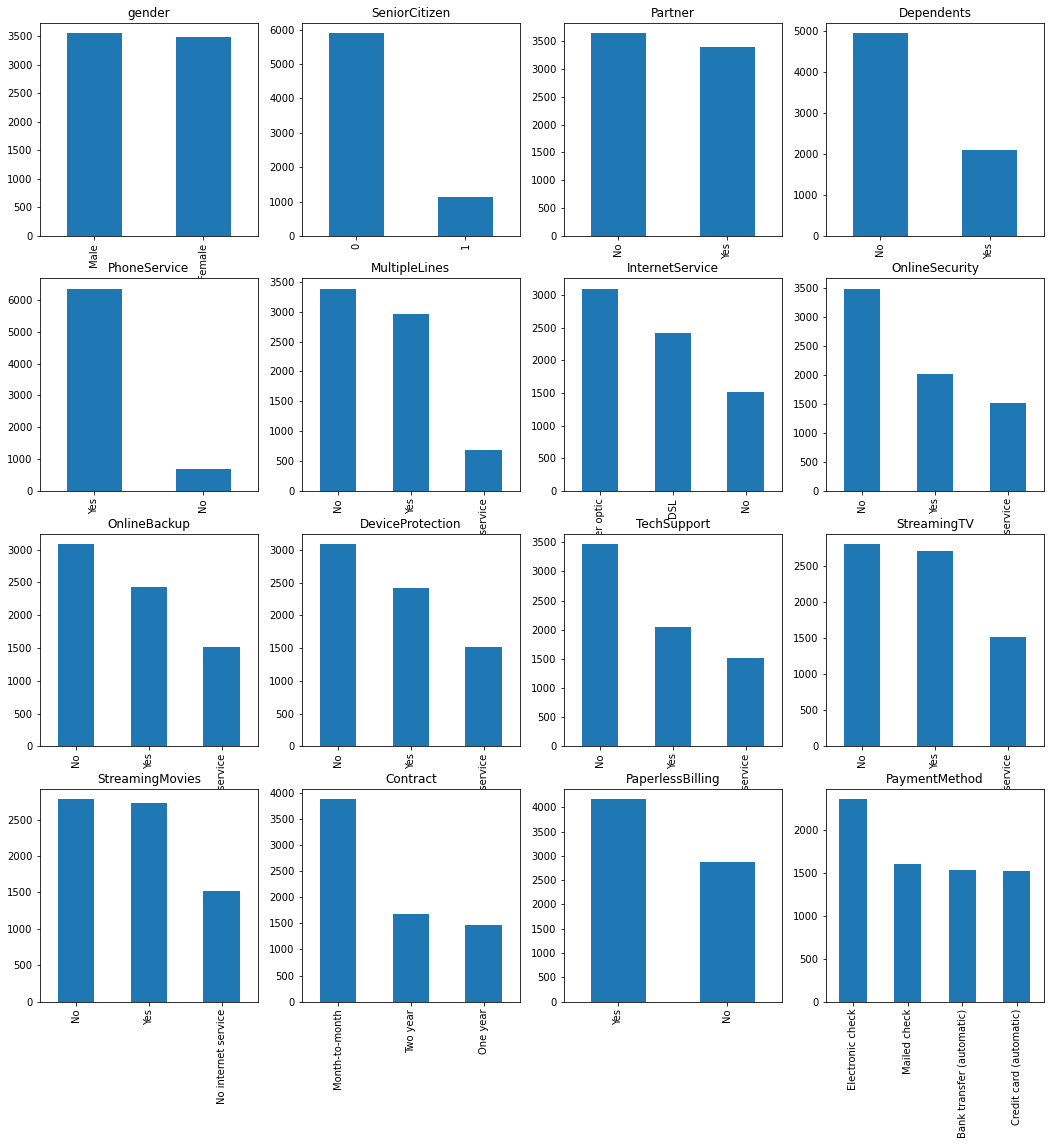

In [14]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col]).set_title(categorical_feature)

The next step is to look at categorical features in relation to the target variable. We do this only for contract feature. Users who have a month-to-month contract are more likely to churn than users with long term contracts.

Text(0.5, 1.0, 'churned')

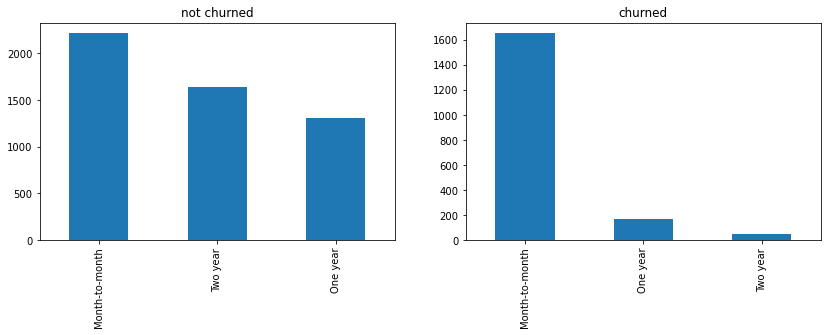

In [15]:
feature = 'Contract'
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df[df.Churn == "No"][feature].value_counts().plot(kind='bar', ax=ax[0]).set_title('not churned')
df[df.Churn == "Yes"][feature].value_counts().plot(kind='bar', ax=ax[1]).set_title('churned')

#### Target variable distribution

Target variable distribution shows that we are dealing with an imbalanced problem as there are many more non-churned as churned users. The model would achieve high accuracy as it would mostly predict majority class - users who didn't churn in our example.

Few things we can do to minimize the influence of imbalanced dataset:
- resample data (https://imbalanced-learn.readthedocs.io/en/stable/),
- collect more samples,
- use precision and recall as accuracy metrics.

Text(0.5, 1.0, 'churned')

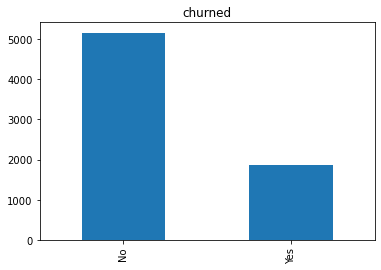

In [16]:
df[target].value_counts().plot(kind='bar').set_title('churned')

## Features

Telco dataset is already grouped by customerID so it is difficult to add new features. When working on the churn prediction we usually get a dataset that has one entry per customer session (customer activity in a certain time). Then we could add features like: 
 - number of sessions before buying something,
 - average time per session,
 - time difference between sessions (frequent or less frequent customer),
 - is a customer only in one country.

Sometimes we even have customer event data, which enables us to find patterns of customer behavior in relation to the outcome (churn).

### Encoding features

To prepare the dataset for modeling churn, we need to encode categorical features to numbers. This means encoding "Yes", "No" to 0 and 1 so that algorithm can work with the data. This process is called [onehot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/).

In [17]:
from sklearn.preprocessing import LabelEncoder

categorical_feature_names = []
label_encoders = {}
for categorical in categorical_features + [target]:
    label_encoders[categorical] = LabelEncoder()
    df[categorical] = label_encoders[categorical].fit_transform(df[categorical])
    names = label_encoders[categorical].classes_.tolist()
    print('Label encoder %s - values: %s' % (categorical, names))
    if categorical == target:
        continue
    categorical_feature_names.extend([categorical + '_' + str(name) for name in names])

Label encoder gender - values: ['Female', 'Male']
Label encoder SeniorCitizen - values: [0, 1]
Label encoder Partner - values: ['No', 'Yes']
Label encoder Dependents - values: ['No', 'Yes']
Label encoder PhoneService - values: ['No', 'Yes']
Label encoder MultipleLines - values: ['No', 'No phone service', 'Yes']
Label encoder InternetService - values: ['DSL', 'Fiber optic', 'No']
Label encoder OnlineSecurity - values: ['No', 'No internet service', 'Yes']
Label encoder OnlineBackup - values: ['No', 'No internet service', 'Yes']
Label encoder DeviceProtection - values: ['No', 'No internet service', 'Yes']
Label encoder TechSupport - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingTV - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingMovies - values: ['No', 'No internet service', 'Yes']
Label encoder Contract - values: ['Month-to-month', 'One year', 'Two year']
Label encoder PaperlessBilling - values: ['No', 'Yes']
Label encoder PaymentMethod - values

In [18]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


## Classifier

We use sklearn, a Machine Learning library in Python, to create a classifier.
The sklearn way is to use pipelines that define feature processing and the classifier. In our example, the pipeline takes a dataset in the input, it preprocesses features and trains the classifier.
When trained, it takes the same input and returns predictions in the output. 

In the pipeline, we separately process categorical and numerical features. We onehot encode categorical features and scale numerical features by removing the mean and scaling them to unit variance.
We chose a decision tree model because of its interpretability and set max depth to 3 (arbitrarily).

In [19]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

In [20]:
pipeline = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                transformer_list=[
                    (
                        "categorical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=categorical_features)),
                                ("onehot", OneHotEncoder()),
                            ]
                        ),
                    )
                ]
                + [
                    (
                        "numerical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=numerical_features)),
                                ("scalar", StandardScaler()),
                            ]
                        ),
                    )
                ]
            ),
        ),
        ("classifier", tree.DecisionTreeClassifier(random_state=42)),
    ]
)

### Training the model

We split the dataset to train (75% samples) and test (25% samples). 
We train (fit) the pipeline and make predictions. 

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)

param_grid = {'classifier__max_depth': [1,2,3,4,5,6,7,None], 
              'classifier__min_samples_leaf': np.arange(1, 9), 
              'classifier__min_samples_split': np.arange(2, 9),
              'classifier__min_weight_fraction_leaf': np.linspace(0, 0.5, 5),
              'classifier__class_weight': ['balanced', None],
              'classifier__min_impurity_decrease': np.linspace(0, 1, 5)}
# param_grid = {'classifier__max_depth': np.arange(3, 7), 
#               'classifier__min_samples_leaf': np.arange(1, 9), 
#               'classifier__min_samples_split': np.arange(2, 9),
#               'classifier__min_impurity_decrease': np.linspace(0, 0.5, 5)}

tree_cv = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)

tree_cv.fit(df_train, df_train[target])
pred = tree_cv.predict(df_test)

print("Tuned Decision Tree: {}".format(tree_cv.best_params_))
print('Accuracy of DecisionTree classifier on test set: {:.2f}'.format(tree_cv.score(df_test, df_test[target])))

Tuned Decision Tree: {'classifier__class_weight': None, 'classifier__max_depth': 6, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0}
Accuracy of DecisionTree classifier on test set: 0.78


### Testing the model

With classification_report we calculate precision and recall with actual and predicted values.
For class 1 (churned users) model achieves 0.67 precision and 0.37 recall.
Precision tells us how many churned users did our classifier predicted correctly. On the other side, recall tell us how many churned users it missed. In layman terms, the classifier is not very accurate for churned users.

In [22]:
from sklearn.metrics import classification_report

print(classification_report(df_test[target], pred))

precision    recall  f1-score   support

           0       0.84      0.87      0.85      1300
           1       0.59      0.52      0.55       458

    accuracy                           0.78      1758
   macro avg       0.71      0.70      0.70      1758
weighted avg       0.77      0.78      0.78      1758



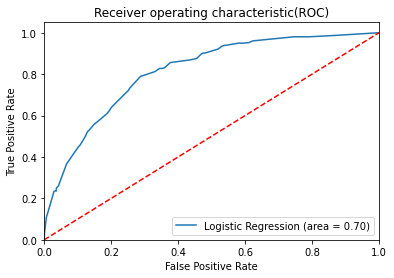

In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(df_test[target], tree_cv.predict(df_test))
fpr, tpr, thresholds = roc_curve(df_test[target], tree_cv.predict_proba(df_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


## Model interpretability

Decision Tree model uses Contract, MonthlyCharges, InternetService, TotalCharges, and tenure features to make a decision if a customer will churn or not. These features separate churned customers from others well based on the split criteria in the decision tree.

Each customer sample traverses the tree and final node gives the prediction. 
For example, if Contract_Month-to-month is:
 - equal to 0, continue traversing the tree with True branch, 
 - equal to 1, continue traversing the tree with False branch, 
 - not defined, it outputs the class 0.
 
This is a great approach to see how the model is making a decision or if any features sneaked in our model that shouldn't be there.

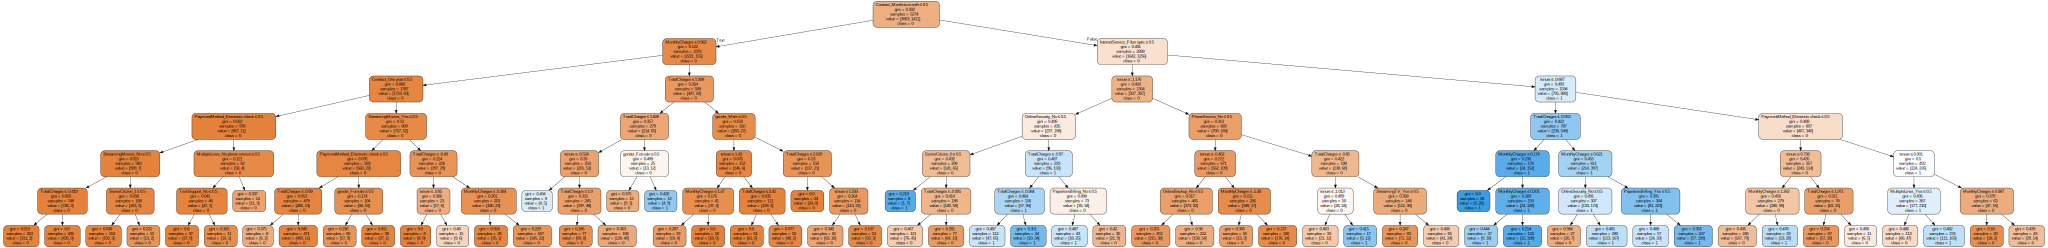

In [24]:
# get pipeline
pipeline = tree_cv.best_estimator_

dot_data = tree.export_graphviz(pipeline.named_steps['classifier'], out_file=None, 
                         feature_names = categorical_feature_names + numerical_features,
                         class_names=[str(el) for el in pipeline.named_steps['classifier'].classes_],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

## Further reading

- [Handling class imbalance in customer churn prediction](https://www.sciencedirect.com/science/article/pii/S0957417408002121) - how can we better handle class imbalance in churn prediction.
- [A Survey on Customer Churn Prediction using Machine Learning Techniques](https://www.researchgate.net/publication/310757545_A_Survey_on_Customer_Churn_Prediction_using_Machine_Learning_Techniques) - This paper reviews the most popular machine learning algorithms used by researchers for churn  predicting.
- [Telco customer churn on kaggle](https://www.kaggle.com/blastchar/telco-customer-churn) - churn analysis on kaggle.
- [WTTE-RNN-Hackless-churn-modeling](https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling) - event based churn prediction.